In [3]:
import numpy as np
import pandas as pd
import keras
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
print("Loading dataset...")

# Load FER-2013 dataset
data = pd.read_csv('fer2013_converted.csv')
pixels = data['pixels'].tolist()
faces = []

for pixel_sequence in pixels:
    face = np.array([int(pixel) for pixel in pixel_sequence.split()], dtype='float32').reshape(48, 48)
    faces.append(face)

faces = np.array(faces)
faces = np.expand_dims(faces, -1)
faces = faces / 255.0  # Normalize pixel values to [0,1]

emotions = to_categorical(data['emotion'], num_classes=7)

print("Dataset loaded. Shape of faces:", faces.shape)
print("Shape of labels:", emotions.shape)

Loading dataset...
Dataset loaded. Shape of faces: (35887, 48, 48, 1)
Shape of labels: (35887, 7)


Splitting dataset...
Setting up data augmentation...
Building improved model...
Starting training with EarlyStopping...
Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 134s 295ms/step - accuracy: 0.2208 - loss: 2.9134 - val_accuracy: 0.2474 - val_loss: 1.8145
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - accuracy: 0.2580 - loss: 1.7886 - val_accuracy: 0.3214 - val_loss: 1.6953
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 141s 314ms/step - accuracy: 0.2773 - loss: 1.7251 - val_accuracy: 0.3773 - val_loss: 1.5527
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 137s 305ms/step - accuracy: 0.3176 - loss: 1.6636 - val_accuracy: 0.3612 - val_loss: 1.5515
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 134s 298ms/step - accuracy: 0.3386 - loss: 1.6372 - val_accuracy: 0.3750 - val_loss: 1.5488
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 300ms/step - accuracy: 0.3586 - loss: 1.5917 - val_accuracy: 0.4223 - val_loss: 1.4684
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 133s 296ms/step - accuracy: 0.3764 - loss: 1.562

Saving model...


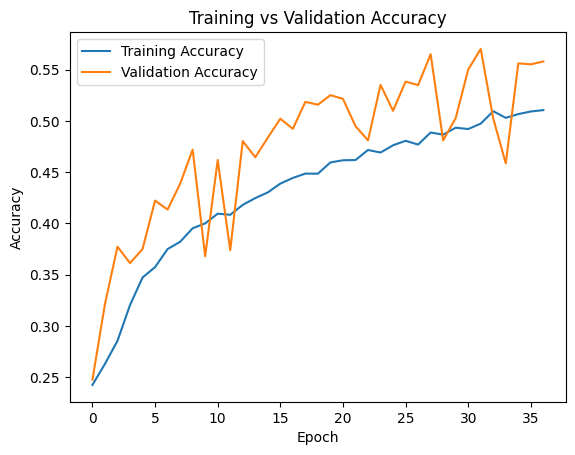

In [8]:
print("Splitting dataset...")
X_train, X_val, y_train, y_val = train_test_split(faces, emotions, test_size=0.2, random_state=42)

print("Setting up data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

print("Building improved model...")
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Starting training with EarlyStopping...")
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=[early_stop])

print("Saving model...")
model.save('improved_emotion_model.h5')

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


In [9]:
print("Launching real-time emotion recognition...")
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
model = tf.keras.models.load_model('improved_emotion_model.h5')
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces_detected = face_classifier.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces_detected:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (48,48))
        roi = roi.astype('float32') / 255.0
        roi = np.expand_dims(roi, axis=0)
        roi = np.expand_dims(roi, axis=-1)

        preds = model.predict(roi, verbose=0)
        label = emotion_labels[np.argmax(preds)]
        confidence = np.max(preds)

        cv2.rectangle(frame, (x, y), (x+w, y+h), (255,0,0), 2)
        cv2.putText(frame, f"{label} ({confidence*100:.1f}%)", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    cv2.imshow('Real-time Emotion Recognition - Press q to Quit', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Launching real-time emotion recognition...
